# 1. Подготовка к работе

In [1]:
# Подгружаем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools

%matplotlib inline

In [2]:
# Подготавливаем общие настройки для графиков

sns.set(
    rc={
        "figure.figsize": (16, 6),
        "axes.titlesize": 20,
        "axes.labelsize": 17,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
    }
)

sns.set_style("whitegrid")
sns.set_palette("PuRd", 10)

In [3]:
# Настраиваем отображение float-чисел
pd.options.display.float_format = '{:,.2f}'.format

# 2. Загрузка данных

Имеется следующая информация:

BillNo — 6-значный номер, присваиваемый каждой транзакции  
Itemname — название продукта  
Quantity — количество каждого продукта за транзакцию  
Date — день и время создания каждой транзакции  
Price — цена продукта  
CustomerID — пятизначный номер, присваиваемый каждому клиенту  
Country — название страны, в которой проживает каждый клиент  

In [4]:
# Считываем данные

path_to_file = 'retail_data.csv'
retail_data = pd.read_csv(path_to_file, sep=';', on_bad_lines='skip', dtype={'BillNo': str})

### Предварительное исследование данных таблицы retail_data

In [5]:
# Проверим первые 5 строк
retail_data.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55","17,850.00",United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39","17,850.00",United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75","17,850.00",United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39","17,850.00",United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39","17,850.00",United Kingdom


In [6]:
# Переименуем столбцы для удобства и изменим их порядок
retail_data.columns = retail_data.columns.str.lower()
retail_data = retail_data.rename(columns={'billno': 'bill', 'itemname': 'item', 'customerid': 'customer_id'})
retail_data = retail_data[['bill', 'customer_id', 'date', 'country', 'item', 'price', 'quantity']]
retail_data.head()

,bill,customer_id,date,country,item,price,quantity
0,536365,"17,850.00",01.12.2010 08:26,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,"2,55",6
1,536365,"17,850.00",01.12.2010 08:26,United Kingdom,WHITE METAL LANTERN,"3,39",6
2,536365,"17,850.00",01.12.2010 08:26,United Kingdom,CREAM CUPID HEARTS COAT HANGER,"2,75",8
3,536365,"17,850.00",01.12.2010 08:26,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,"3,39",6
4,536365,"17,850.00",01.12.2010 08:26,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,"3,39",6


In [7]:
# Посмотрим размер данных
retail_data.shape

(522064, 7)

In [8]:
# Посмотрим тип переменных
retail_data.dtypes

bill            object
customer_id    float64
date            object
country         object
item            object
price           object
quantity         int64
dtype: object

In [9]:
# Приведем столбцы к нужным форматам
retail_data.customer_id = retail_data.customer_id.fillna('-').astype(str).replace('\.0', '', regex=True)
retail_data.date = pd.to_datetime(retail_data.date, dayfirst=True)
retail_data.price = retail_data.price.str.replace(',', '.').astype(float)

In [10]:
# Проверим тип переменных
retail_data.dtypes

bill                   object
customer_id            object
date           datetime64[ns]
country                object
item                   object
price                 float64
quantity                int64
dtype: object

In [11]:
# Посмотрим общую статистику
retail_data.describe()

,price,quantity
count,"522,064.00","522,064.00"
mean,3.83,10.09
std,41.90,161.11
min,"-11,062.06","-9,600.00"
25%,1.25,1.00
50%,2.08,3.00
75%,4.13,10.00
max,"13,541.33","80,995.00"


Видим, что у нас есть отрицательная цена и отрицательное количество, такого быть не должно, удалим эти записи.

In [12]:
retail_data = retail_data.query("quantity > 0 and price > 0")

In [13]:
# Еще раз посмотрим общую статистику
retail_data.describe()

,price,quantity
count,"519,551.00","519,551.00"
mean,3.89,10.40
std,35.95,157.00
min,0.00,1.00
25%,1.25,1.00
50%,2.08,3.00
75%,4.13,10.00
max,"13,541.33","80,995.00"


In [14]:
# Проверим наличие пропущенных значений
retail_data.isna().sum()

bill           0
customer_id    0
date           0
country        0
item           0
price          0
quantity       0
dtype: int64

In [15]:
# Проверим наличие дубликатов
retail_data.duplicated().sum()

5281

In [16]:
# Удалим дубликаты
retail_data = retail_data.drop_duplicates()

In [17]:
# Посмотрим количество уникальных значений
retail_data.nunique()

bill           19559
customer_id     4297
date           18148
country           30
item            4006
price           1283
quantity         374
dtype: int64

Теперь с данными все в порядке, можно приступать к анализу.

# 3. Анализ данных

In [18]:
# Наши данные
retail_data.head()

,bill,customer_id,date,country,item,price,quantity
0,536365,17850,2010-12-01 08:26:00,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,2.55,6
1,536365,17850,2010-12-01 08:26:00,United Kingdom,WHITE METAL LANTERN,3.39,6
2,536365,17850,2010-12-01 08:26:00,United Kingdom,CREAM CUPID HEARTS COAT HANGER,2.75,8
3,536365,17850,2010-12-01 08:26:00,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,6
4,536365,17850,2010-12-01 08:26:00,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,3.39,6


In [19]:
# Добавим столбец с доходом и месяцем-годом покупки
retail_data['revenue'] = retail_data.price * retail_data.quantity
retail_data['month_year'] = retail_data.date.dt.to_period('M')
retail_data.head()

,bill,customer_id,date,country,item,price,quantity,revenue,month_year
0,536365,17850,2010-12-01 08:26:00,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,2.55,6,15.30,2010-12
1,536365,17850,2010-12-01 08:26:00,United Kingdom,WHITE METAL LANTERN,3.39,6,20.34,2010-12
2,536365,17850,2010-12-01 08:26:00,United Kingdom,CREAM CUPID HEARTS COAT HANGER,2.75,8,22.00,2010-12
3,536365,17850,2010-12-01 08:26:00,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,6,20.34,2010-12
4,536365,17850,2010-12-01 08:26:00,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,3.39,6,20.34,2010-12


In [20]:
# Определим период наблюдений
print(f'Данные за период: {min(retail_data.date)} - {max(retail_data.date)}')

Данные за период: 2010-12-01 08:26:00 - 2011-12-09 12:50:00


Видим, что данные у нас собраны за год, этого достаточно для проведения ABC/XYZ-анализа.

## 1. ABC-анализ пользователей и товаров

<b><span style='color:#9e88b6'>Принцип Парето: 20% усилий приносят 80% результата </span></b>  

Классификацируем объекты по влиянию на прибыль компании, разделим на три группы:

**Группа A.** Самые ценные — в теории 20%, приносящих 80% прибыли.  
**Группа B.** Промежуточные — в теории 30%, приносящие 15% прибыли.  
**Группа C.** Наименее ценные — в теории 50%, которые приносят 5% прибыли.

Порядок деления на группы (функция perform_abc):

1. Группируем по исследуемому объекту (пользователи, товары).
2. Считаем доход, который приносит объект.
3. Считаем долю каждого товара в общем объёме выручки.
4. Сортируем в порядке убывания вклада в выручку.
5. Считаем нарастающий итог.
6. Определяем группы в зависимости от выручки по совокупному проценту. С показателем меньше 80% относятся к группе A, 80–95% — к группе B, 95–100% — к группе C.

In [21]:
# Функция для распределения по группам ABC

def perform_abc(df, attribute):
    
    grouped_data = df.groupby(attribute).agg({'revenue': 'sum'})
    grouped_data['part_revenue'] = grouped_data['revenue'] / sum(grouped_data['revenue'])
    grouped_data = grouped_data.sort_values('part_revenue', ascending=False)
    grouped_data['cumsum_revenue'] = grouped_data['part_revenue'].cumsum()
    grouped_data['abc_group'] = np.where(grouped_data['cumsum_revenue'] < 0.8, 'A', 
                                               np.where(grouped_data['cumsum_revenue'] < 0.95, 'B', 'C'))
    
    return grouped_data[['revenue', 'abc_group']].reset_index()

### ABC-анализ пользователей

In [22]:
# Распределяем пользователей по группам, убрав неопределенных пользователей
customer_data = retail_data.query("customer_id != '-'")
customer_abc = perform_abc(customer_data, attribute='customer_id')
customer_abc.head()

,customer_id,revenue,abc_group
0,14646,"280,206.02",A
1,18102,"259,657.30",A
2,17450,"194,390.79",A
3,16446,"168,472.50",A
4,12415,"124,914.53",A


In [23]:
# Найдем количество пользователей и их долю от общего числа в каждой группе
customer_group = customer_abc.groupby('abc_group', as_index=False).agg(customer_count=('customer_id', 'count'))
customer_group['count_percent'] = customer_group.customer_count / customer_group.customer_count.sum()
customer_group

,abc_group,customer_count,count_percent
0,A,1143,0.27
1,B,1454,0.34
2,C,1699,0.40


### ABC-анализ товаров

In [24]:
# Распределяем товары по группам
item_abc = perform_abc(retail_data, attribute='item')
item_abc.head()

,item,revenue,abc_group
0,DOTCOM POSTAGE,"206,248.77",A
1,"PAPER CRAFT , LITTLE BIRDIE","168,469.60",A
2,REGENCY CAKESTAND 3 TIER,"165,411.99",A
3,WHITE HANGING HEART T-LIGHT HOLDER,"102,532.32",A
4,PARTY BUNTING,"97,308.38",A


In [25]:
# Найдем количество товаров и их долю от общего числа в каждой группе
item_group = item_abc.groupby('abc_group', as_index=False).agg(item_count=('item', 'count'))
item_group['count_percent'] = item_group.item_count / item_group.item_count.sum()
item_group

,abc_group,item_count,count_percent
0,A,822,0.21
1,B,1001,0.25
2,C,2183,0.54


### Результат ABC-анализа

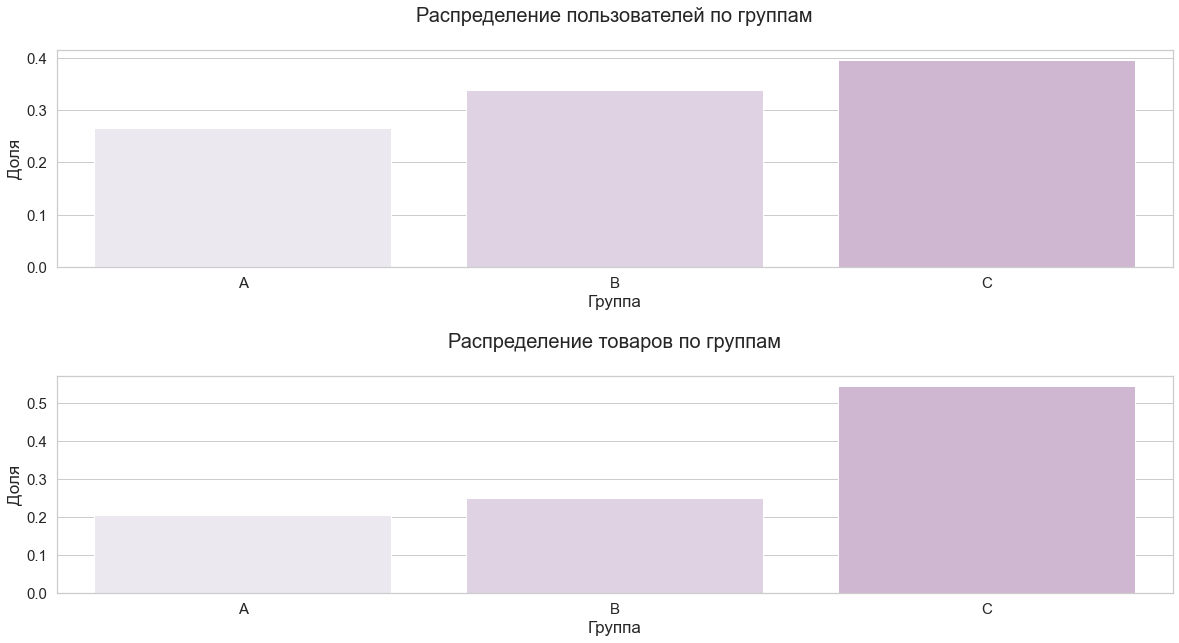

In [26]:
# Построим полученные распределения

fig, axs = plt.subplots(2, 1, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
sns.barplot(data=customer_group, x='abc_group', y='count_percent', ax=axs[0]) \
    .set(ylabel='Доля', xlabel='Группа', title='Распределение пользователей по группам\n')
sns.barplot(data=item_group, x='abc_group', y='count_percent', ax=axs[1]) \
    .set(ylabel='Доля', xlabel='Группа', title='Распределение товаров по группам\n')
plt.show()

**Вывод:** из полученных таблиц и графиков видим:  
- 27% пользователей принесли 80% выручки  
- 21% товаров принесли 80% выручки.    

Данные результаты хорошо согласуются с принципом Парето.    

Результаты данного анализа можно использовать для подбора дальнейшей стратегии. Например, в случае товаров:  
Товары из **группы А** можно дополнительно продвигать — упомянуть в рассылке, пуш-уведомлениях, провести акции с ними.  
Товары из **группы B** стоит закупить в таком количестве, чтобы покрыть спрос.  
Товары из **группы C** стоит либо прекратить продавать, либо уменьшить их запасы.

## 2. XYZ-анализ пользователей и товаров

XYZ-анализ применяется для определения характера спроса. С его помощью можно понять, насколько стабильными являются продажи (как часто пользователь совершает покупку или как часто покупают тот или иной товар).  

**Группа X**. Объекты с коэффициентом вариативности 0–10% — спрос не меняется более, чем на 10% в месяц, стабильные покупки, высокая степень прогнозирования.   
**Группа Y**. Объекты с коэффициентом вариативности 10–25% — нерегулярные покупки, средние возможности для прогнозирования, могут зависеть от сезонности.   
**Группа Z**. Объекты с коэффициентом вариативности больше 25% или новые объекты, единичные покупки — невозможно спрогнозировать.  

Порядок деления на группы (функция perform_xyz):  

1. Группируем по дате (смотрим в разбивке по месяцам) и объекту (пользователь, товар).
2. Рассчитываем стандартное отклонение, среднее дохода от объекта, и с их помощью находим коэффициент вариации.
3. Определяем, к какой группе относится каждый объект. С коэффициентом 0–10% попадают в группу X, 10–25% — в группу Y, более 25% или новые объекты (единичные покупки) — в группу Z.

In [27]:
# Функция для распределения по группам XYZ

def perform_xyz(df, attribute):
    
    grouped_data = df.groupby(['month_year', attribute], as_index=False).agg({'revenue': 'sum'})
    grouped_data = grouped_data.groupby(attribute, as_index=False).agg(mean_v =('revenue', 'mean'),
                                                                       std_v=('revenue', 'std'))
    grouped_data['var_coeff'] = grouped_data.std_v / grouped_data.mean_v
    grouped_data['xyz_group'] = np.where(grouped_data['var_coeff'] < 0.1, 'X', 
                               np.where(grouped_data['var_coeff'] < 0.25, 'Y', 'Z'))
    grouped_data = grouped_data.sort_values('var_coeff')


    return grouped_data[[attribute, 'var_coeff', 'xyz_group']]

### XYZ-анализ пользователей

In [28]:
# Распределяем пользователей по группам
customer_xyz = perform_xyz(customer_data, attribute='customer_id')
customer_xyz.head()

,customer_id,var_coeff,xyz_group
1593,14548,0.00,X
1892,14987,0.00,X
3391,17029,0.00,X
3614,17353,0.00,X
26,12384,0.00,X


In [29]:
# Найдем количество пользователей и их долю от общего числа в каждой группе
customer_group = customer_xyz.groupby('xyz_group', as_index=False).agg(customer_count=('customer_id', 'count'))
customer_group['percent'] = customer_group.customer_count / customer_group.customer_count.sum()
customer_group

,xyz_group,customer_count,percent
0,X,235,0.05
1,Y,403,0.09
2,Z,3658,0.85


### XYZ-анализ товаров

In [30]:
# Распределяем товары по группам
item_xyz = perform_xyz(retail_data, attribute='item')
item_xyz.head()

,item,var_coeff,xyz_group
3322,SILVER/BLACK PENDANT ORBIT NECKLACE,0.00,X
1717,I LOVE LONDON WALL ART,0.00,X
3005,SET 10 CARDS CHRISTMAS HOLLY 17259,0.00,X
2957,RUSTIC STRAWBERRY JAMPOT SMALL,0.00,X
283,BAROQUE BUTTERFLY EARRINGS PINK,0.00,X


In [31]:
# Найдем количество товаров и их долю от общего числа в каждой группе
item_group = item_xyz.groupby('xyz_group', as_index=False).agg(item_count=('item', 'count'))
item_group['percent'] = item_group.item_count / item_group.item_count.sum()
item_group

,xyz_group,item_count,percent
0,X,56,0.01
1,Y,42,0.01
2,Z,3908,0.98


### Результаты XYZ-анализа

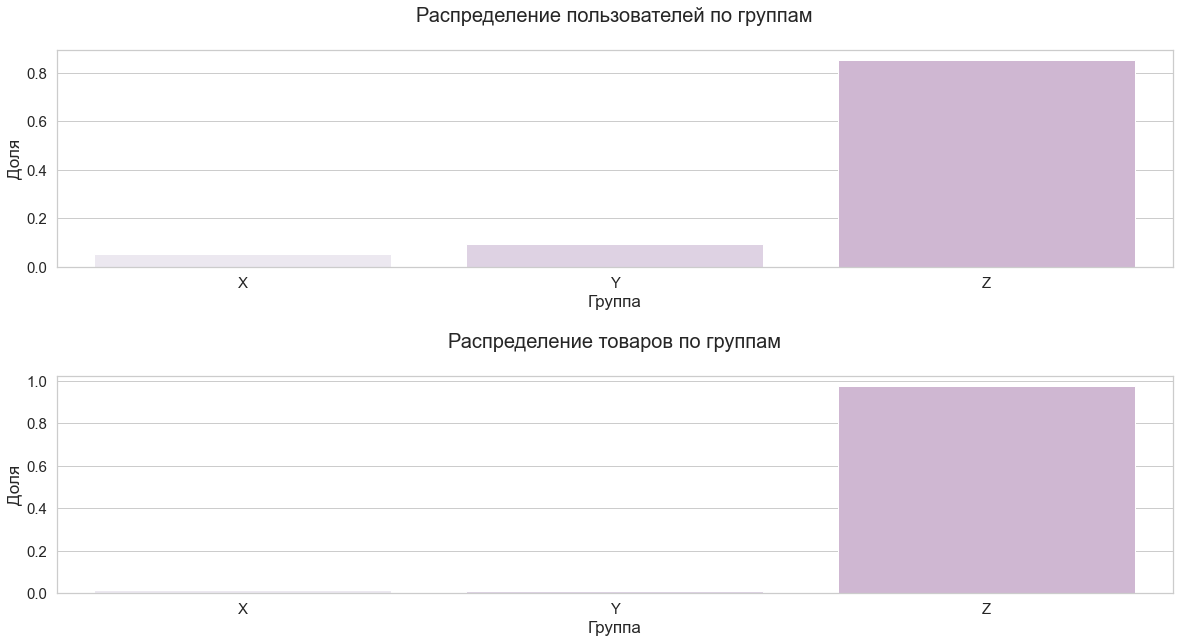

In [32]:
# Построим полученные распределения

fig, axs = plt.subplots(2, 1, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
sns.barplot(data=customer_group, x='xyz_group', y='percent', ax=axs[0]) \
    .set(ylabel='Доля', xlabel='Группа', title='Распределение пользователей по группам\n')
sns.barplot(data=item_group, x='xyz_group', y='percent', ax=axs[1]) \
    .set(ylabel='Доля', xlabel='Группа', title='Распределение товаров по группам\n')
plt.show()

**Вывод:** из полученных таблиц и графиков видим: 
- и для пользователей, и для товаров преобладают покупки с большим коэффициентом вариативности или единичные покупки, то есть делать какие-либо прогнозы по ним сложно  
- нужно обратить внимание на объекты со стабильным спросом
  
По данному анализу можно судить о спросе у пользователей или на товар, однако он не лишен минусов (резкий скачок спроса может испортить картину; анализ дает картину колебаний, но не учитывает факторы, которые к ним приводят и так далее), поэтому для наибольшей эффективности можно использовать ABC/XYZ-анализ, который комбинирует два анализа.

## 3. ABC/XYZ-анализ пользователей и товаров

### ABC/XYZ-анализ пользователей

В данном анализе уже не 3 группы, а 9 групп:  

AX — большая доля прибыли, стабильный спрос.  
AY — большая доля прибыли, колеблющийся спрос.  
AZ — большая доля прибыли, непредсказуемый спрос.  
BX — средние объёмы прибыли, стабильный спрос.  
BY — средние объёмы прибыли, колеблющийся спрос.  
BZ — средние объёмы прибыли, непредсказуемый спрос.  
CX — малозначительная прибыль, стабильный спрос.  
CY — малозначительная прибыль, колеблющийся спрос.  
CZ — малозначительная прибыль, непредсказуемый спрос.  

In [33]:
# Соединим полученные ранее таблицы с делением по группам
customer_abcxyz = customer_abc.merge(customer_xyz, on='customer_id', how='left')
customer_abcxyz['abcxyz_group'] = customer_abcxyz.abc_group + customer_abcxyz.xyz_group
customer_abcxyz = customer_abcxyz.sort_values('revenue', ascending=False)
customer_abcxyz.head()

,customer_id,revenue,abc_group,var_coeff,xyz_group,abcxyz_group
0,14646,"280,206.02",A,0.58,Z,AZ
1,18102,"259,657.30",A,0.83,Z,AZ
2,17450,"194,390.79",A,1.26,Z,AZ
3,16446,"168,472.50",A,1.41,Z,AZ
4,12415,"124,914.53",A,0.70,Z,AZ


In [34]:
# Посмотрим информацию по группам
result_customer = customer_abcxyz.groupby('abcxyz_group', as_index=False) \
                              .agg(customers_count=('customer_id', 'count'),
                                   revenue = ('revenue', 'sum')) \
                              .sort_values('revenue', ascending=False)
result_customer['count_percent'] = result_customer.customers_count / result_customer.customers_count.sum()
result_customer

,abcxyz_group,customers_count,revenue,count_percent
2,AZ,1001,"6,401,050.97",0.23
5,BZ,1111,"989,990.38",0.26
8,CZ,1546,"379,185.19",0.36
1,AY,113,"324,503.41",0.03
4,BY,207,"183,102.36",0.05
3,BX,136,"108,630.47",0.03
0,AX,29,"106,116.74",0.01
7,CY,83,"26,961.47",0.02
6,CX,70,"20,922.01",0.02


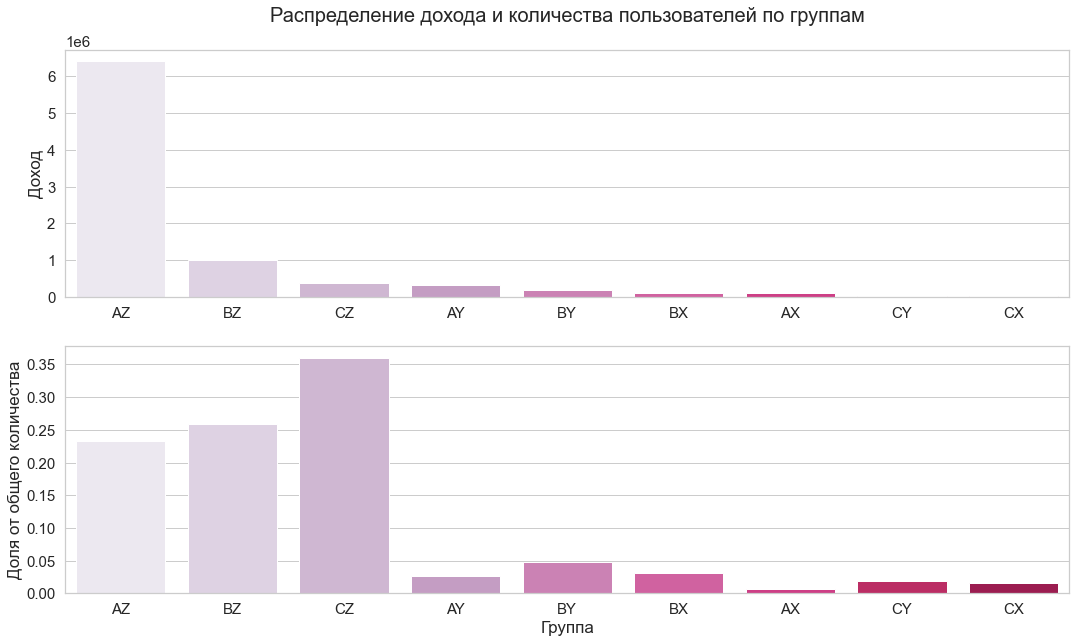

In [35]:
# Посмотрим на распределение
fig, axs = plt.subplots(2, 1, figsize=(18, 10))
sns.barplot(data=result_customer, x='abcxyz_group', y='revenue', ax=axs[0]) \
    .set(ylabel='Доход', xlabel='', title='Распределение дохода и количества пользователей по группам\n')
sns.barplot(data=result_customer, x='abcxyz_group', y='count_percent', ax=axs[1]) \
    .set(ylabel='Доля от общего количества', xlabel='Группа')
plt.show()

**Выводы:** 
- Больше всего прибыли совершили клиенты из группы AZ, эти клиенты нестабильные, однако у них есть потенциал, с этими клиентами нужно усиленно работать, выводя их на постоянные большие объемы, доля этих клиентов большая.
- Больше всего пользователей в группе СZ, эти клиенты непредсказуемые, возможно, это новые клиенты, или у них были сезонные покупки, нужно изучить их внимательнее.
- Лучших клиентов AX небольшое количество, нужно работать с ними внимательнее, напоминать о себе, делать скидки и предложения.
- Доход от группы СX мал, эти пользователи покупают постоянно, но мало.
- Также большой доход от клиентов группы BZ, их доля приличная, эти клиенты нестабильные, но приносят доход, нужно поднимать у них объемы покупок.

Дополнительно следует провести когортный анализ пользователей и RFM-анализ.

### ABC/XYZ-анализ товаров

In [36]:
# Соединим полученные ранее таблицы с делением по группам
item_abcxyz = item_abc.merge(item_xyz, on='item', how='left')
item_abcxyz['abcxyz_group'] = item_abcxyz.abc_group + item_abcxyz.xyz_group
item_abcxyz = item_abcxyz.sort_values('revenue', ascending=False)
item_abcxyz.head()

,item,revenue,abc_group,var_coeff,xyz_group,abcxyz_group
0,DOTCOM POSTAGE,"206,248.77",A,0.49,Z,AZ
1,"PAPER CRAFT , LITTLE BIRDIE","168,469.60",A,NaN,Z,AZ
2,REGENCY CAKESTAND 3 TIER,"165,411.99",A,0.42,Z,AZ
3,WHITE HANGING HEART T-LIGHT HOLDER,"102,532.32",A,0.50,Z,AZ
4,PARTY BUNTING,"97,308.38",A,0.73,Z,AZ


In [37]:
# Посмотрим информацию по группам
result_item = item_abcxyz.groupby('abcxyz_group', as_index=False) \
                              .agg(items_count=('item', 'count'),
                                   revenue = ('revenue', 'sum')) \
                              .sort_values('revenue', ascending=False)
result_item['count_percent'] = result_item.items_count / result_item.items_count.sum()
result_item

,abcxyz_group,items_count,revenue,count_percent
1,AZ,817,"8,158,539.01",0.20
3,BZ,996,"1,537,486.14",0.25
6,CZ,2095,"507,526.64",0.52
0,AY,5,"62,124.62",0.00
2,BY,5,"5,315.14",0.00
5,CY,32,"3,425.24",0.01
4,CX,56,"2,971.38",0.01


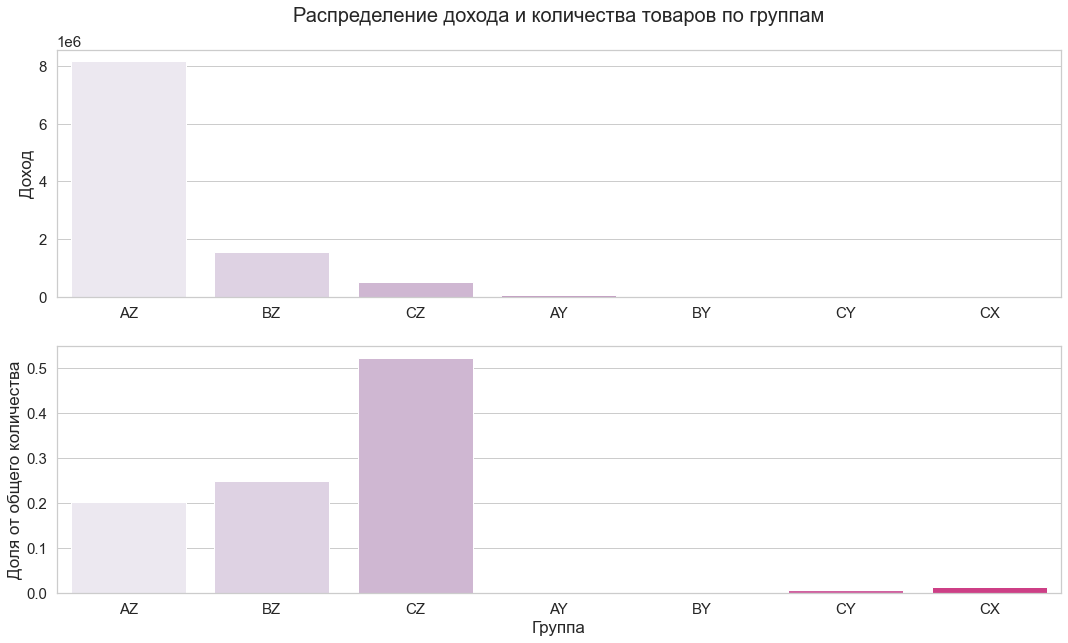

In [38]:
# Посмотрим на распределение
fig, axs = plt.subplots(2, 1, figsize=(18, 10))
sns.barplot(data=result_item, x='abcxyz_group', y='revenue', ax=axs[0]) \
    .set(ylabel='Доход', xlabel='', title='Распределение дохода и количества товаров по группам\n')
sns.barplot(data=result_item, x='abcxyz_group', y='count_percent', ax=axs[1]) \
    .set(ylabel='Доля от общего количества', xlabel='Группа')
plt.show()

**Выводы:**

- Больше всего дохода нам приносят группы AZ, BZ — при высокой выручке отличаются низкой прогнозируемостью. Попытка обеспечить гарантированное наличие по всем товарам данных групп только за счет избыточного страхового товарного запаса приведет к тому, что средний товарный запас компании значительно увеличится. Поэтому по товарам данной группы следует пересмотреть систему заказов:
    - перевести часть товаров на систему заказов с постоянной суммой (объемом) заказа
    - обеспечить по части товаров более частые поставки
    - повысить периодичность контроля
    - поручить работу с данной группой товаров самому опытному менеджеру компании
    
- Больше всего товаров относятся к группе СZ — в нее попадают все новые товары, товары спонтанного спроса, поставляемые под заказ. Часть этих товаров можно безболезненно выводить из ассортимента, а другую часть нужно регулярно контролировать. Данные товары требуют дополнительного анализа, так как выручка от них есть.

- AY могут перейти в группу AX — самые ценные товары, в нашем случае товаров в данной группе нет. Спрос на них можно стимулировать: например, расположив эти товары на первых страницах каталогов. Но данных товаров очень маленькое количество.  

- Остальные группы приносят минимальную выручку, стоит провести дополнительные исследования.

**Итог:** наблюдается очень низкая прогнозируемость, нужно стимулировать спрос на товары.

## 4. Общая динамика продаж
### По месяцам

In [39]:
# Посмотрим на количество покупок и доход от них по месяцам
retail_by_month = retail_data.groupby('month_year', as_index=False) \
                             .agg(revenue=('revenue', 'sum'), purchases_count=('bill', 'nunique'))
retail_by_month

,month_year,revenue,purchases_count
0,2010-12,"807,215.78",1538
1,2011-01,"665,727.01",1075
2,2011-02,"503,060.52",1077
3,2011-03,"679,471.26",1420
4,2011-04,"527,214.75",1229
5,2011-05,"749,008.99",1655
6,2011-06,"727,311.20",1496
7,2011-07,"669,497.00",1441
8,2011-08,"732,944.09",1332
9,2011-09,"1,006,294.61",1789


In [40]:
# Определим последнюю дату
max(retail_data['date'])

Timestamp('2011-12-09 12:50:00')

Не будем в анализ брать декабрь 2011 года, так как он неполный, только до 9 числа.

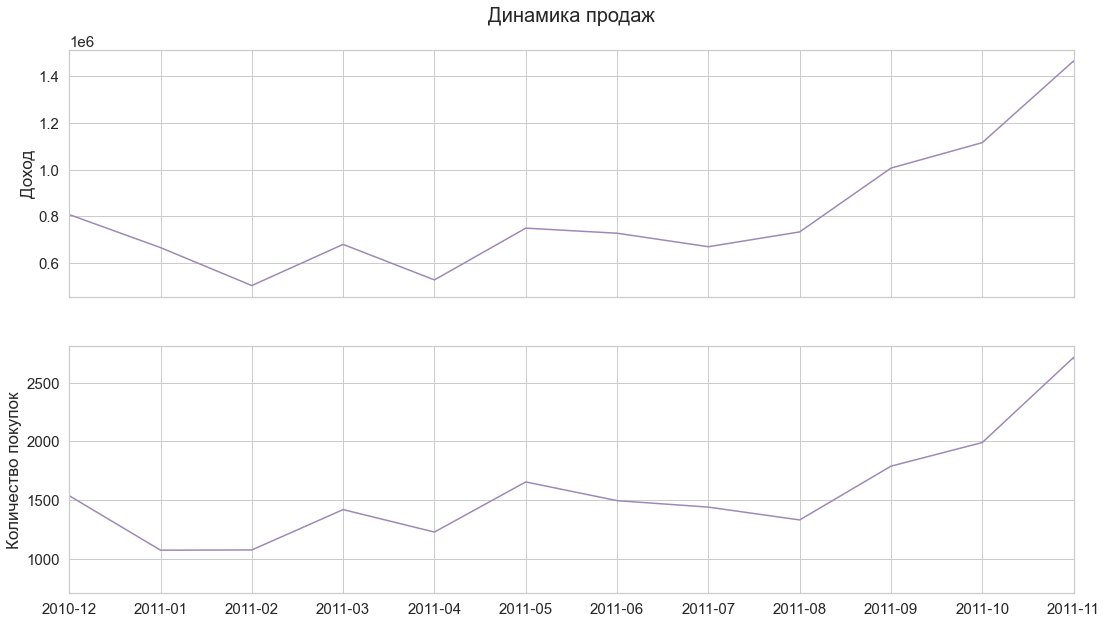

In [41]:
# Посмотрим на распределение по датам
fig, axs = plt.subplots(2, 1, figsize=(18, 10))
sns.lineplot(data=retail_by_month, x=retail_by_month['month_year'].astype(str), y='revenue', 
             color='#9e88b6', ax=axs[0]).set(xlim=('2010-12', '2011-11'), xlabel='', ylabel='Доход',
                                             title='Динамика продаж\n', xticklabels=[])
sns.lineplot(data=retail_by_month, x=retail_by_month['month_year'].astype(str), y='purchases_count', 
             color='#9e88b6', ax=axs[1]).set(xlim=('2010-12', '2011-11'), xlabel='', 
                                             ylabel='Количество покупок',)
plt.show()

В общей динамике наблюдается рост и дохода, и количества покупок, с некими колебаниями. Заметный рост наблюдается с сентября по ноябрь, что может указывать на сезонность.

### По странам

In [42]:
# Посмотрим на количество пользователей и доход от них по странам
by_country = retail_data.groupby('country', as_index=False) \
                                 .agg(customers_count=('customer_id', 'nunique'),
                                     revenue=('revenue', 'sum')) \
                                 .sort_values('customers_count', ascending=False).reset_index()
del by_country['index']
by_country.head(10)

,country,customers_count,revenue
0,United Kingdom,3921,"9,001,410.16"
1,Germany,94,"228,678.40"
2,France,88,"209,625.37"
3,Spain,30,"61,558.56"
4,Belgium,25,"41,196.34"
5,Switzerland,22,"57,067.60"
6,Portugal,20,"33,683.05"
7,Italy,14,"17,483.24"
8,Austria,11,"10,198.68"
9,Norway,10,"36,165.44"


Наибольший вклад дает United Kingdom, объединим остальные страны и посмотрим соотношение.

In [43]:
# Объединяем все страны, кроме United Kingdom
UK_other = pd.concat([by_country[:1], pd.DataFrame(by_country.loc[1:].sum()).transpose()], 
                                      ignore_index=True)
UK_other.loc[1, 'country'] = 'other countries'
UK_other

,country,customers_count,revenue
0,United Kingdom,3921,"9,001,410.16"
1,other countries,386,"1,275,978.01"


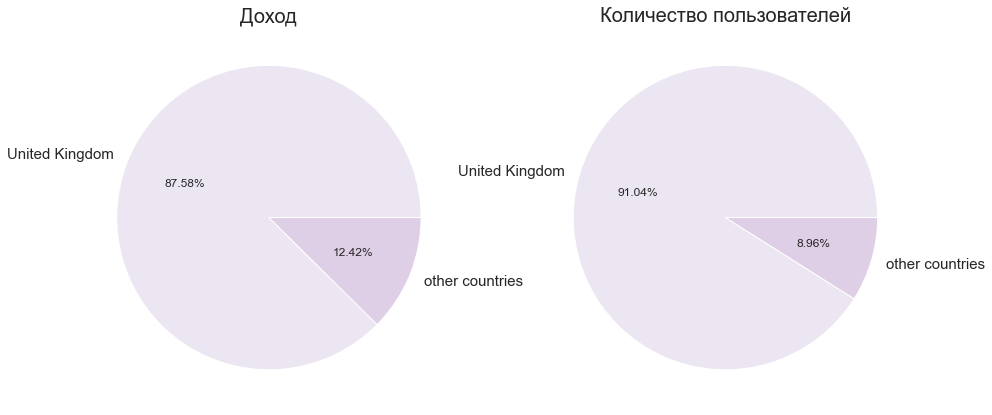

In [44]:
# Визуализируем отношение

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(121)
ax1 = plt.pie(UK_other.revenue, labels=['United Kingdom', 'other countries'], autopct='%.2f%%')
plt.title('Доход')
ax2 = fig.add_subplot(122)
ax2 = plt.pie(UK_other.customers_count, labels=['United Kingdom', 'other countries'], autopct='%.2f%%')
plt.title('Количество пользователей')
plt.show()

In [45]:
# Посмотрим на среднй чек и размер корзины по странам
bill = retail_data.groupby(['country', 'bill'], as_index=False) \
                                 .agg(revenue=('revenue', 'sum'),
                                     size=('quantity', 'sum'))
avg_bill = bill.groupby('country', as_index=False) \
               .agg(avg_revenue=('revenue', 'mean'), avg_size=('size', 'mean')) \
               .sort_values('avg_revenue', ascending=False)
avg_bill.head(10)

,country,avg_revenue,avg_size
22,Singapore,"3,039.90",748.71
16,Netherlands,"3,036.66","2,131.50"
0,Australia,"2,429.01","1,471.77"
12,Japan,"1,969.28","1,369.26"
13,Lebanon,"1,693.88",386.00
8,Hong Kong,"1,407.55",428.45
4,Brazil,"1,143.60",356.00
24,Sweden,"1,065.77","1,002.17"
25,Switzerland,"1,056.81",566.98
10,Israel,"1,014.93",549.75


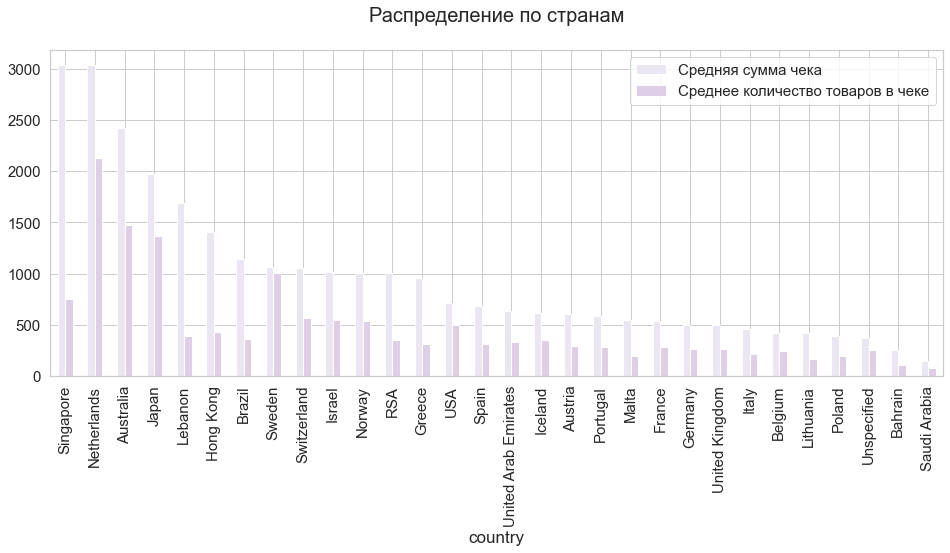

In [46]:
# Визуализируем распределение
avg_bill.plot(kind='bar', x='country')
plt.legend(['Средняя сумма чека', 'Среднее количество товаров в чеке'], fontsize='15')
plt.title('Распределение по странам\n')
plt.show()

Видим, что United Kingdom, которая является лидером по выручке, не входит в топ-15 стран по среднему чеку, United Kingdom приносит большой доход за счет большого числа пользователей, в то же время Singapore и Netherlands, которые являются лидерами по размеру среднего чека, не входят в топ-10 стран по выручке и числу пользователей, поэтому приносят не такой большой доход как United Kingdom из-за единичных покупателей. Также у Netherlands наблюдается очень большое значение среднего количества товаров в корзине, скорее всего, это оптовый покупатель.

**Таким образом, был проведен ABC-анализ, XYZ-анализ, ABC/XYZ-анализ, была посмотрена общая динамика продаж по месяцам и странам.**